# Appendix: Photometric redshift regression for galaxies

## Authors: 
Djordje Savic (Postdoc)  
Isidora Jankov (PhD student)

## Assistant:  
Iva Čvorović-Hajdinjak (PhD student)

## Code specification

**Reproducibility:**  
This is an end-to-end example reproducible in the SciServer Essentials 2.0 with the preinstalled Python environment "py38" with tensorflow installed.
The user should navigate to Stripe82 Object Table 's82ObjectTable.parquet'.  
This notebook has been run on a server with 80 cores and 512 GB RAM memory with no additional packages installed.

**Should the notebook be run on the blinded dataset?**  
We would like this model to be evaluated on the blinded dataset if there is a separate subsample of galaxies only.

**Working with already trained models**  
There are no saved models in this example due to the fast training on SciServer

**Code version:** in development phase

**Sample:** Tests performed on a subsample with size of ~50000. The total sample of galaxies with non NaN values is ~100000).


## Contents:

1. Introduction and motivation
2. Data reading and pre-processing
3. Neural network regression
4. Random forest regression
5. Conclusion

## 1. Introduction  and motivation
The main goal of this work aims at building a data driven model for unsupervised form of classification problem and AGN selection with the future LSST sky survey. We used a deep embedding clustering (DEC) approach ([Xie et al. 2015](https://arxiv.org/abs/1511.06335)). In this example, the original model has been adjusted and the code has been adapted for treating the problem on tabular data. A more complex model with object images and Improved Deep Embedded Clustering ([Guo et al. 2017](https://www.ijcai.org/proceedings/2017/0243.pdf)) is currently in consideration by SER-SAG team..

In [23]:
## commonly used modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import yaml
import seaborn as sns

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
#import MLdefs

pd.set_option('display.max_columns', 1000)

In [24]:
## Data challenge root data dir
#data_dir = "./Datasets/"
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

# Examine the data directory
display(data_dir)

'/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/'

## 2. Data reading and pre-processing

The object table follows the current version of the LSST Data Products document (LSE-163) as much as possible with measurements of included objects in the following main catalogries:
- __Astromety__ -> ra, dec, proper motion and parallax
- __Photometry__ -> point and extended source photometry, in both AB magnitdues and fluxes (nJy)
- __Color__ -> Computed using the fluxes
- __Morphology__ -> 1 for extended and 0 for point-like
- __Light Curve Features__ -> Extrated on the SDSS light curves if matched
- __Redshift__ -> Both spectroscopic and photometric, wherever available

In [26]:
# reading S82 object table
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))
#object_df = pd.read_csv(os.path.join(data_dir, 's82ObjectTableDF.csv')) #
display(object_df.describe())
display(object_df.shape)
# Number of objects in each class + unlabeled
display(object_df['class'].value_counts())
display("Number of unlabeled objects: {}".format(object_df['class'].isna().sum()))

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPerio

(436990, 380)

Gal         212349
Star         93001
Qso          72393
highZQso       989
Agn            849
Name: class, dtype: int64

'Number of unlabeled objects: 57409'

Selection of this particular set of parameters was guided by inspecting the correlation matrix for all parameters given
in Stripe82 Object Table. Subset of parameters with good separation between at least two classes (see the Appendix notebook)
The proper motion was excluded in this example.

In [28]:
attr_list = [
             'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
             'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
             #'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i', 'extendedness_z', 'extendedness_y',
             'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
             'class', 
             'photoZ_pest', 
             'z',
            ]

# Removing NaN values
obj_df = obj_df[attr_list].dropna()
qso_df = obj_df[obj_df['class'] == 'Qso']
gal_df = obj_df[obj_df['class'] == 'Gal']

#qso_df = qso_df.dropna()
display(qso_df.columns, qso_df.shape, gal_df.shape)
#display(qso_df['fuv_mag'].dropna())

Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
       'class', 'photoZ_pest', 'z'],
      dtype='object')

(3979, 20)

(109912, 20)

array([[<AxesSubplot:title={'center':'psMag_u'}>,
        <AxesSubplot:title={'center':'psMag_g'}>,
        <AxesSubplot:title={'center':'psMag_r'}>,
        <AxesSubplot:title={'center':'psMag_i'}>],
       [<AxesSubplot:title={'center':'psMag_z'}>,
        <AxesSubplot:title={'center':'psMag_y'}>,
        <AxesSubplot:title={'center':'bdMag_u'}>,
        <AxesSubplot:title={'center':'bdMag_g'}>],
       [<AxesSubplot:title={'center':'bdMag_r'}>,
        <AxesSubplot:title={'center':'bdMag_i'}>,
        <AxesSubplot:title={'center':'bdMag_z'}>,
        <AxesSubplot:title={'center':'bdMag_y'}>],
       [<AxesSubplot:title={'center':'stdColor_0'}>,
        <AxesSubplot:title={'center':'stdColor_1'}>,
        <AxesSubplot:title={'center':'stdColor_2'}>,
        <AxesSubplot:title={'center':'stdColor_3'}>],
       [<AxesSubplot:title={'center':'stdColor_4'}>,
        <AxesSubplot:title={'center':'photoZ_pest'}>,
        <AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

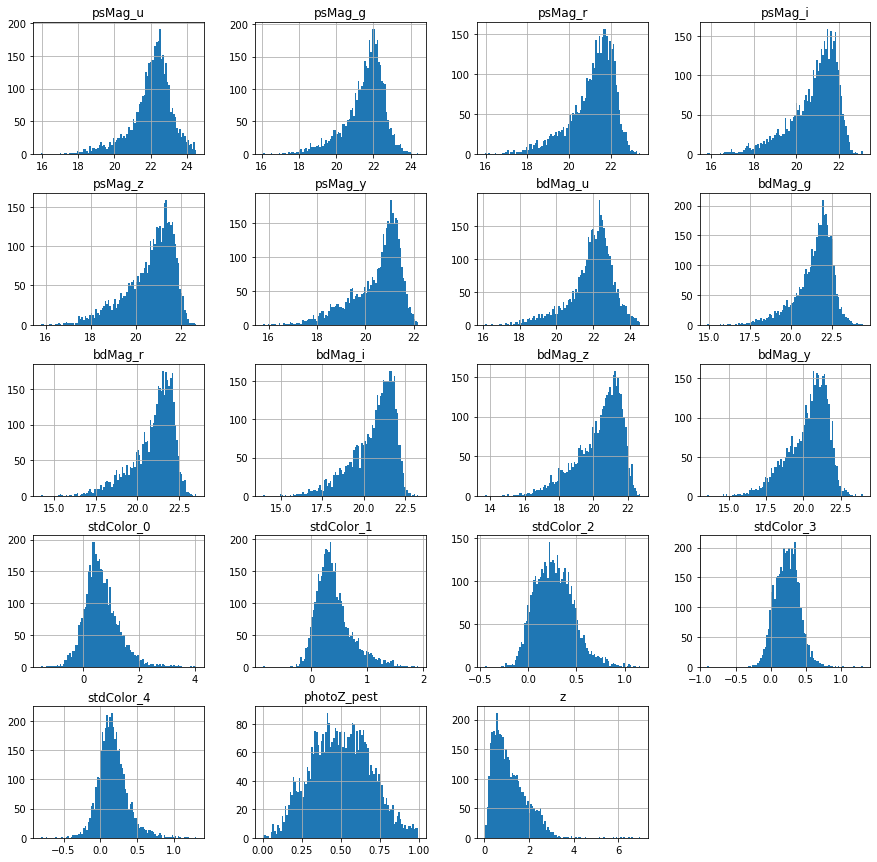

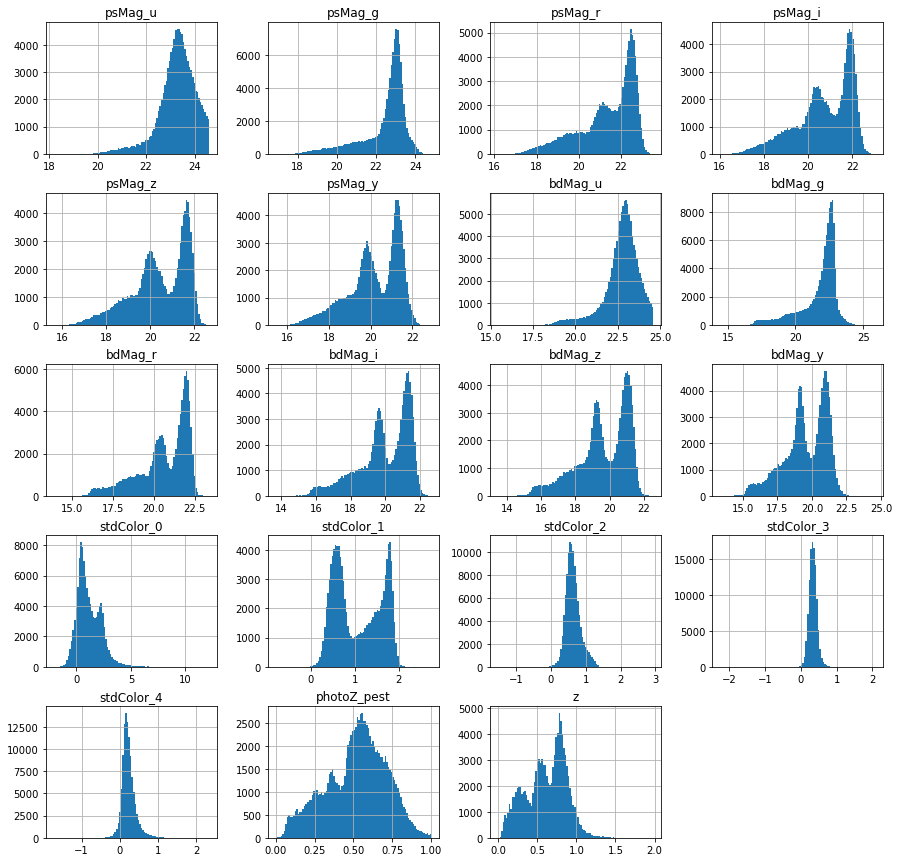

In [29]:
# Nan values are removed, we proceed with further inspection of the data
# Quick histograms of selected attributes, colors are approximately Gaussian distributed
qso_df.hist(figsize = [15,15], bins=100)
gal_df.hist(figsize = [15,15], bins=100)

Assigning X and y from the sample. After dropping NaN or missing values, 
we are left with a subsample consisting of 109912 galaxies that have both spectroscopic and photometric redshifts measured. 
This is roughly 1/4 of the total number of objects in the Stripe82 Object Table (436990 objects with known labels).

In [48]:
# we use galaxy data frame
qso_df = gal_df
qso_df = qso_df.loc[qso_df['z'] <= 2]
y_df = qso_df[['z', 'photoZ_pest']]
X_df = qso_df.drop(['z', 'class', 'photoZ_pest'], axis=1)


display(X_df.shape, y_df.shape)
display(X_df.columns)

(109912, 17)

(109912, 2)

Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4'],
      dtype='object')

In [31]:
X = X_df
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_df, test_size = 0.5, random_state = 1)
## standardization using StandardScaler applied to X_train (yields mean and sigma for X_train)
## and then standardizing X_train and X_test and X_unlab with mean and sigma obtained from X_train
scalerX = preprocessing.StandardScaler()
scalerX.fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

y_test_photoZ_pest = y_test['photoZ_pest']

y_train = y_train.drop(['photoZ_pest'], axis=1) # dropping photoZ_pest
y_test = y_test.drop(['photoZ_pest'], axis=1)

## 3. Neural network regression
Preliminary architecture design computations, number of neurons, hidden layers etc... We have 3 hidden layers only.
Train for up to ~20 epochs with loss mean absolute error is less sensitive to outliers than mse.

In [47]:

n_input_layer = X_train.shape[1]
n_output_layer = 1 + 0*y_train.shape[0]
n_middle_layer = int(2/3*n_input_layer) + 1
n_layer = 2
num_epochs = 10
#display(n_layer, n_input_layer, n_output_layer, n_middle_layer)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)



model = tf.keras.Sequential([
                            tf.keras.layers.Input(n_input_layer),
                            tf.keras.layers.Dense(n_input_layer, activation='relu'),
                            tf.keras.layers.Dense(n_input_layer, activation='relu'),
                            tf.keras.layers.Dense(n_middle_layer, activation='relu'),
                            tf.keras.layers.Dense(3, activation='relu'),
                            tf.keras.layers.Dense(1, activation='relu'),
                            ])
model.compile(optimizer='adam',
              loss='mae',
              #loss=tf.keras.losses.LogCosh(),
              )
display(model.summary())


history = model.fit(X_train, y_train, epochs=num_epochs)
scores = model.evaluate(X_test, y_test, verbose=0)
display(scores)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_44 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_45 (Dense)             (None, 12)                216       
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 39        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 4         
Total params: 871
Trainable params: 871
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/10
1718/1718 [==============================] - 13s 8ms/step - loss: 0.0637
Epoch 2/10
1718/1718 [==============================] - 13s 7ms/step - loss: 0.0464
Epoch 3/10
1718/1718 [==============================] - 14s 8ms/step - loss: 0.0444
Epoch 4/10
1718/1718 [==============================] - 12s 7ms/step - loss: 0.0431
Epoch 5/10
1718/1718 [==============================] - 13s 7ms/step - loss: 0.0422
Epoch 6/10
1718/1718 [==============================] - 13s 8ms/step - loss: 0.0415
Epoch 7/10
1718/1718 [==============================] - 13s 8ms/step - loss: 0.0409
Epoch 8/10
1718/1718 [==============================] - 12s 7ms/step - loss: 0.0406
Epoch 9/10
1718/1718 [==============================] - 13s 8ms/step - loss: 0.0403
Epoch 10/10
1718/1718 [==============================] - 13s 8ms/step - loss: 0.0399


0.03900272026658058

Plotting the results. Redshift is on x-axis (spectroscopic), Photo-Z is our estimate.

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


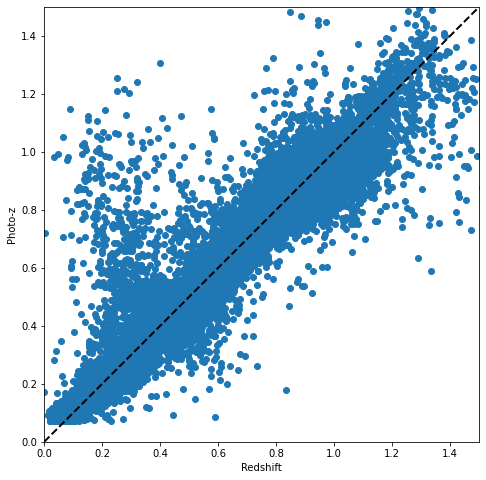

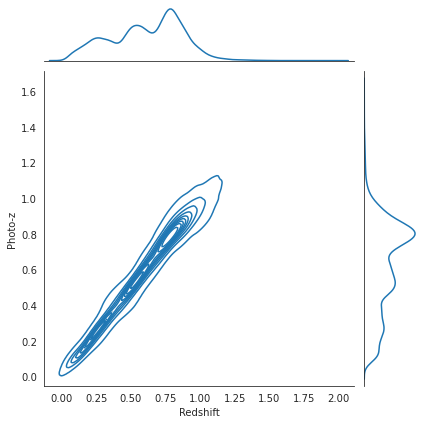

In [43]:
y_test_pl = np.squeeze(y_test)
y_pred = np.squeeze(model.predict(X_test))
#print(y_test.shape, y_pred.shape)
yydf = pd.DataFrame({'Redshift':y_test_pl, 'Photo-z':y_pred})

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test_pl, y_pred)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')
ax.plot([0, 2], [0, 2], 'k--', linewidth = 2)
ax.set_xlim((0, 1.5))
ax.set_ylim((0, 1.5))
ax.set_aspect('equal')
with sns.axes_style('white'):
    sns.jointplot('Redshift','Photo-z',yydf, kind='kde')


#plt.xlim(0, 5)
#print(model.predict(X_test))
#print(y_test.shape, y_train.shape)
#plt.scatter(loss_per_fold)
#kind='hue'

0.03869502618908882

0.0015389067102626716

0.0707685579620404

(54956,)

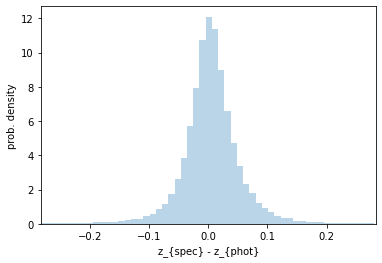

In [38]:
#Plot a histogram of the results. Sometimes better than random forest (sigma is less)
scores = model.evaluate(X_test, y_test, verbose=0)
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=200)
sig_pred = np.std(y_test_pl - y_pred)
mean_pred = np.mean(y_test_pl - y_pred)
plt.hist(y_test_pl-y_pred, **kwargs);
plt.xlim(-4*sig_pred, 4*sig_pred)
plt.xlabel('z_{spec} - z_{phot}')
plt.ylabel('prob. density')
display(scores)
display(mean_pred, sig_pred)
display(y_test_pl.shape)
#model_save_name = './NNcheckpoints/photoZ_loss' + str(np.round(scores, 5)) + '.hp'
#display("Saving photo-Z deep learning model to + " + model_save_name)
#model.save(model_save_name)

## 4. Random forest regression

In [39]:
#Create a random forest regressor

rf = RandomForestRegressor(max_depth=50, random_state=5, n_jobs=70)
rf.fit(X_train, np.array(y_train).ravel())

y_pred_rf = rf.predict(X_test)
yydf = pd.DataFrame({'Redshift':y_test_pl, 'Photo-z':y_pred_rf})

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


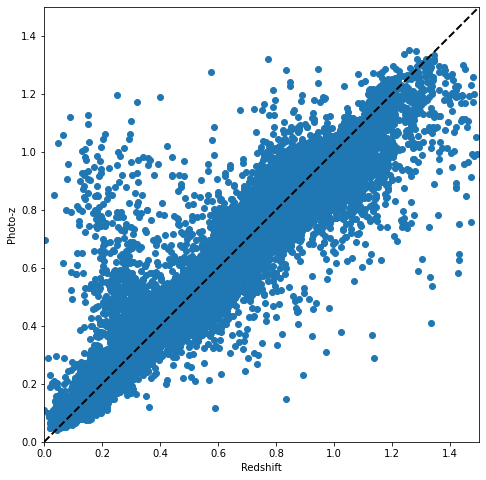

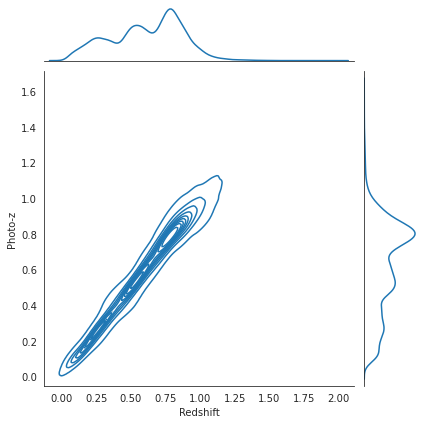

In [44]:
## there is a very similar bump as with neural networks that is for z between 0.2 and 0.4
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test_pl, y_pred_rf)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')
ax.plot([0, 2], [0, 2], 'k--', linewidth = 2)
ax.set_xlim((0, 1.5))
ax.set_ylim((0, 1.5))
ax.set_aspect('equal')
with sns.axes_style('white'):
    sns.jointplot('Redshift', 'Photo-z', yydf, kind='kde')

-0.00028970083253288085

0.07020239464221525

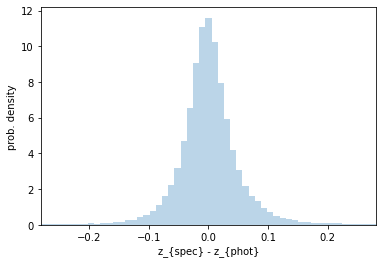

In [45]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=200)
sig_pred_rf = np.std(y_test_pl - y_pred_rf)
mean_pred_rf = np.mean(y_test_pl - y_pred_rf)
plt.hist(y_test_pl-y_pred_rf, **kwargs);
plt.xlim(-4*sig_pred_rf, 4*sig_pred_rf)
plt.ylabel('prob. density')
plt.xlabel('z_{spec} - z_{phot}')
display(mean_pred_rf, sig_pred_rf)

## 5. Conclusion

This notebook demonstrates how photometric redshifts of galaxies could be estimated with machine learning regression: neural networks and random forest. Accuracy score for both methods are comparable for this set of parameters. Neural networks are more unstable per initial conditions and produce similar results regardless of the number of neurons per layer (assuming that the number of neurons is less than the size of the input vector). Adding more hidden layers leads to no significant improvement (tested with ~15 deep layers). Training neural network with mean absolute error as loss performs better than using mean squared error. Random forest slightly outperforms neural network with the architecture used here. This is still a work in progress.